In [42]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from main import ta_dataset

os.environ["MAX_RUNS"] = "5"

In [6]:
def get_stat_avg(exp_name, stat):
    exp_path = Path(f'experiments/ablation/{exp_name}')

    stat_to_avg = []
    for run in range(1, 6):
        run_dir = exp_path / f'run-{run}'
        with open(run_dir / 'stats.json') as f:
            stats = json.load(f)
        vals = np.array([e['value'] for e in stats[stat]])
        stat_to_avg.append(vals)
    return np.mean(stat_to_avg, axis=0)

In [ ]:
COLOR_CYCLE = ['#606060', '#AAAAAA', '#BBBBBB']

def get_latest_model(exp_name):
    experiment_dir = Path(f'experiments/{exp_name}/').absolute()
    if os.path.isdir(experiment_dir / 'saved_models'):
        parent_dir = experiment_dir / 'saved_models'
        saved_models = [m for m in parent_dir.iterdir() if 'nopush' not in m.name]  # only get models after pushing
        saved_models = sorted(saved_models, key=lambda m: m.stat().st_mtime)
        return saved_models[-1]
    else:
        return experiment_dir / 'models' / 'last-epoch.pth'

def latest_epoch(exp_name):
    parent_dir = Path(f'experiments/{exp_name}/protos/')
    if not parent_dir.exists() or not any(parent_dir.iterdir()):
        return None
    latest_subdir = sorted(parent_dir.iterdir(), key=lambda d: d.stat().st_mtime)[-1]
    return latest_subdir.name.replace('epoch-', '')

def plot_single_feature(ax, y, rf_start, rf_end, color):
    x = range(len(y))
    
    if rf_start > 0:
        ax.plot(x[:rf_start+1], y[:rf_start+1], color=color)
    line, = ax.plot(x[rf_start:rf_end], y[rf_start:rf_end], color=color)
    if rf_end < len(y):
        ax.plot(x[rf_end-1:], y[rf_end-1:], color=color)
    return line

def visualize_proto(ts, proto_range, ax=None, proto_bg='#c1d1f077', y_lim=None, facecolor=None, title=None):
    if ax is None:
        _, ax = plt.subplots()
    lines = []
    labels = []

    rf_start = proto_range[0]
    rf_end = proto_range[1]

    default_color_cycle = COLOR_CYCLE
    for i, feat in enumerate(range(ts.shape[0])):
        lines.append(plot_single_feature(ax, ts[feat], rf_start, rf_end, color=default_color_cycle[i%len(default_color_cycle)]))
        labels.append(f'Feature {feat}')
    ax.set_xlim(0, ts.shape[1]-1)
    y_min_max = (np.min(ts[:, :-1]), np.max(ts[:, :-1]))
    y_range = y_min_max[1] - y_min_max[0]
    if y_lim is None:
        ax.set_ylim(y_min_max[0] - 0.2*y_range, y_min_max[1] + 0.2*y_range)
    else:
        ax.set_ylim(y_lim)
    y_lim = ax.get_ylim()
    ax.fill_between(range(rf_start, rf_end), *ax.get_ylim(), color=proto_bg) #, alpha=0.5)
    ax.set_ylim(y_lim)
    
    if facecolor is not None:
        ax.set_facecolor(facecolor)
    if title is not None:
        ax.set_title(title)

def visualize_matrix(matrix, figsize=None, show=True):
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')

    # Annotate the heatmap with the matrix values
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white', fontsize=10)

    plt.xticks(range(matrix.shape[1]))
    plt.yticks(range(matrix.shape[0]))
    plt.gca().grid(False)
    plt.xlabel('Prototypes')
    plt.ylabel('Classes')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="2%", pad=0.05)    
    plt.colorbar(cax=cax)

    if show:
        plt.show()

def calc_feature_importance(experiment_name):
    latest_model = get_latest_model(experiment_name)
    savedir = Path.cwd()
    try:
        os.chdir(Path(f'./experiments/{experiment_name}/').absolute())
        ppnet = torch.load(latest_model, map_location=torch.device('cpu'))
    finally:
        os.chdir(savedir)
    proto_features_importances = []
    for enc_out in range(len(ppnet.features.masks)):
        mask = ppnet.features.masks[enc_out]
        weights_for_enc_out = ppnet.add_on_layers[0].weight.data[:, enc_out, 0]
        product = np.multiply(np.array(mask).reshape((-1, 1)), weights_for_enc_out.numpy().reshape((1, -1)))
        proto_features_importances.append(product)

    feat_importance = np.abs(np.array(proto_features_importances).sum(axis=0)).sum(axis=1)
    return feat_importance / max(np.abs(feat_importance))

In [43]:
train_ds, test_ds = ta_dataset()

Smaller class is class HS: 1728 vs 309


In [13]:
%%bash
EXP_NAME="regular_encoder"
for run in $(seq 1 $MAX_RUNS); do
    echo " ### Run $run/$MAX_RUNS ###"
    ./main.py --experiment_name ablation/$EXP_NAME/run-$run --proto_len 0.5 --protos_per_class 2 --epochs 200 --warm_epochs 50 --pretraining_epochs 100
done

 ### Run 1/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 98.39%
Done in 200 epochs, 32.96s
 ### Run 2/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 97.31%
Done in 200 epochs, 33.86s
 ### Run 3/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 90.32%
Done in 200 epochs, 34.25s
 ### Run 4/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 96.77%
Done in 200 epochs, 33.65s
 ### Run 5/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 91.4

In [ ]:
%%bash
EXP_NAME="vae_with_no_additional_changes"
for run in $(seq 1 $MAX_RUNS); do
    echo " ### Run $run/$MAX_RUNS ###"
    ./main.py --experiment_name ablation/$EXP_NAME/run-$run --proto_len 0.5 --protos_per_class 2 --epochs 200 --warm_epochs 50 --pretraining_epochs 100 --vae_encoder
done

 ### Run 1/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 91.40%
Done in 200 epochs, 33.66s
 ### Run 2/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 97.31%
Done in 200 epochs, 32.69s
 ### Run 3/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 95.70%
Done in 200 epochs, 31.64s
 ### Run 4/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 91.40%
Done in 200 epochs, 32.22s
 ### Run 5/5 ###
Running on custom dataset, loading...
Smaller class is class HS: 1728 vs 309
Scaling dataset...
Training encoder
Training ProtoTSNet
Last epoch test accu: 95.7

In [ ]:
%%bash
EXP_NAME="vae"
for run in $(seq 1 $MAX_RUNS); do
    echo " ### Run $run/$MAX_RUNS ###"
    ./main.py --experiment_name ablation/$EXP_NAME/run-$run --proto_len 0.5 --protos_per_class 2 --epochs 200 --warm_epochs 50 --pretraining_epochs 100
done

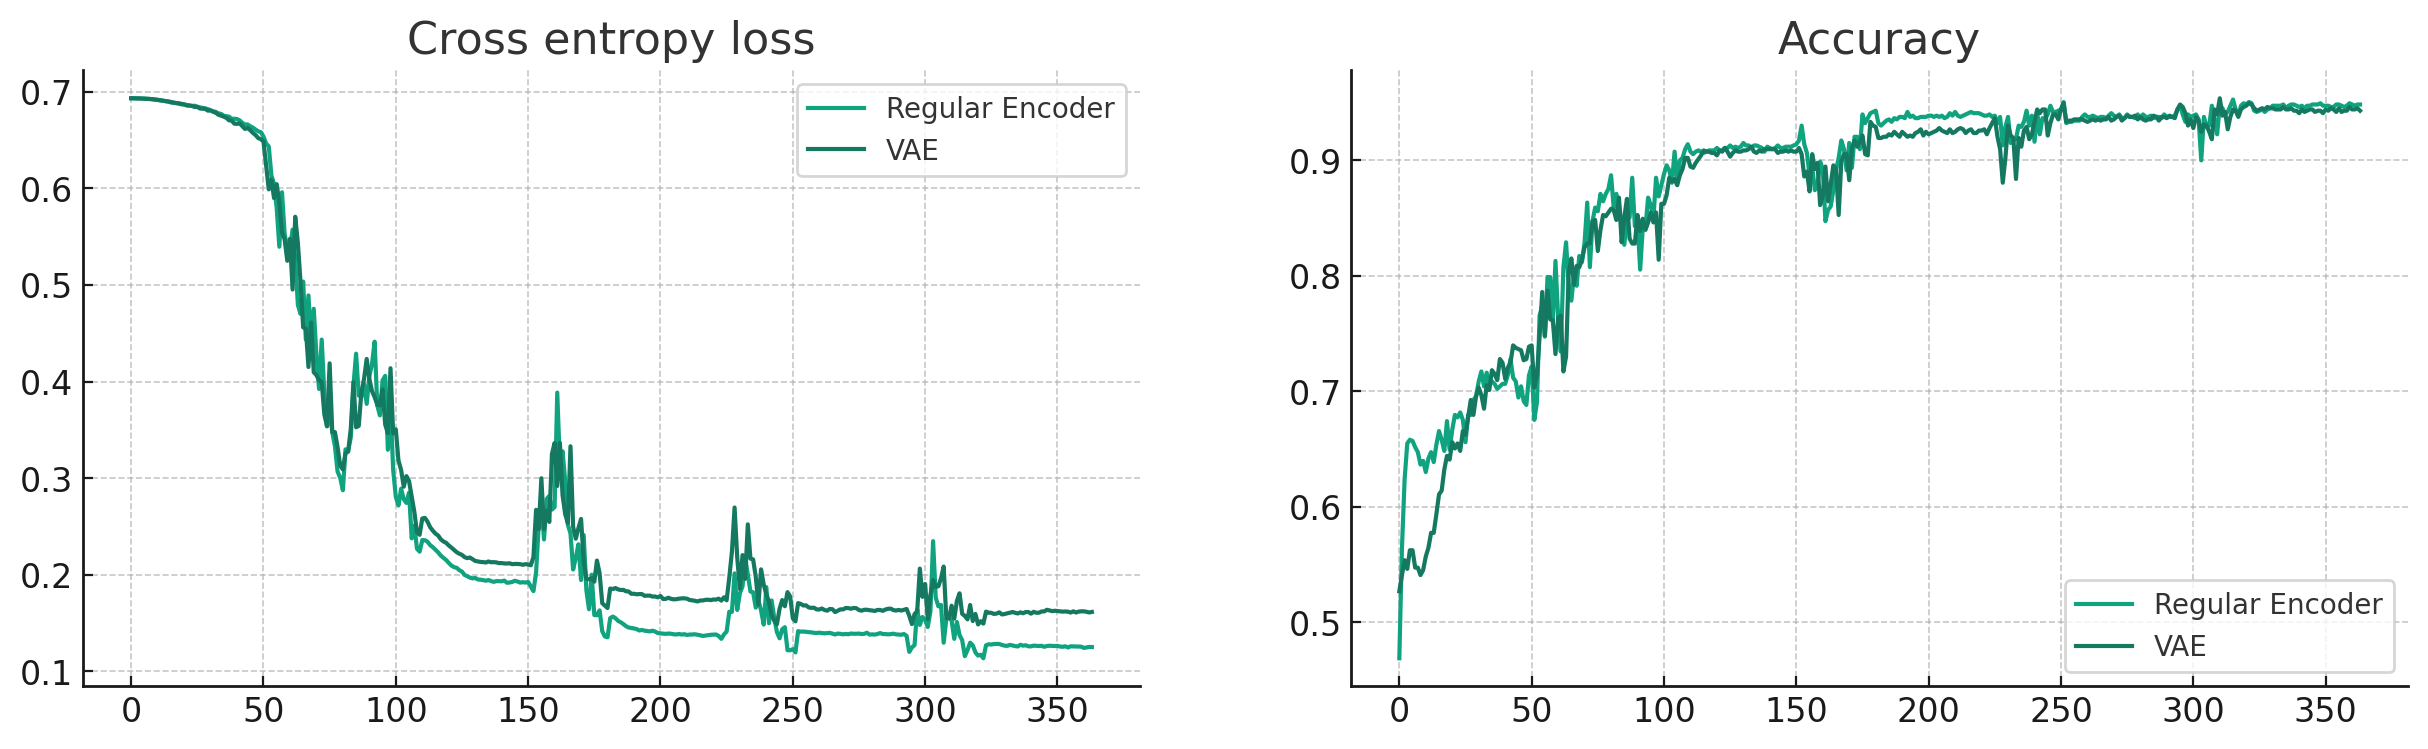

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title('Cross entropy loss')
plt.plot(get_stat_avg('regular_encoder', 'cross_ent_test'), label='Regular Encoder')
plt.plot(get_stat_avg('vae_with_no_additional_changes', 'cross_ent_test'), label='VAE')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(get_stat_avg('regular_encoder', 'accu_test'), label='Regular Encoder')
plt.plot(get_stat_avg('vae_with_no_additional_changes', 'accu_test'), label='VAE')
plt.legend()